# Plot ice thickness observations

In [91]:
##Ben Pelto June 2019
###using this script to plot the thickness

# Python imports
import os
import pandas as pd
import salem
import numpy as np
import xarray as xr
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

##plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import pylab

In [92]:
num = 6 #num determines which gdir and gradient to use, refer to list below to select desired site

#data points gradients
grad = [6.84, 9.8, 7.11, 7.95, 10.84, 6.01, 7.92] # mm w.e. m-1 

srtm = [-1.58, -6.95, -6.47, -5.71, -5.86, -6.11, 0.48]
products_dir = '/home/pelto/Desktop/ice_thick/JoG/'
glacier = ['Kokanee', 'Haig', 'Conrad', 'W.Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']

In [93]:
WORKING_DIR = utils.get_temp_dir('ice_thickness')
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

# cfg.PARAMS['use_rgi_area'] = False
cfg.PARAMS['border'] = 10

# Get the RGI glaciers for the run.
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688'
            , 'RGI60-02.04264', 'RGI60-02.07780']

2019-11-23 13:57:06: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [94]:
rgidf = utils.get_rgi_glacier_entities(rgi_list) 
gdirs = workflow.init_glacier_regions(rgidf)
workflow.gis_prepro_tasks(gdirs)
workflow.climate_tasks(gdirs)
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
# gdir = gdirs[0]
# tasks.init_present_time_glacier(gdirs) 

2019-11-23 13:57:07: oggm.workflow: Execute entity task define_glacier_region on 7 glaciers
2019-11-23 13:57:07: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers()

In [95]:
shapefile = ['2017/Kokanee_17_final_WGS84_clip.shp', 'Haig/Haig_gpr_all_WGS84.shp', 'conrad_GPR_ALL_final_WGS84.shp', 
             'west_wash_data.shp', '2018/illec_may18_final_WGS84.shp', '2016/Nordic_2016_GPR_final_WGS84.shp', 
             'zillmer_GPR_All_final_WGS84.shp']
DF_Final=pd.DataFrame({'Glacier':[],'lat':[],'long':[],'depth':[],'x':[],'y':[]})
##illecillewaet radar data causes failure if using RGI polygon due to data bounds, so I clipped the radar data for now
for i in range(7):
    
    #df = df[i]
    df = salem.read_shapefile('/home/pelto/GIS/GPR/Data/' + shapefile[i])
    coords = np.array([p.xy for p in df.geometry]).squeeze()
    df['lon'] = coords[:, 0]
    df['lat'] = coords[:, 1]
    # df['lon'] = df[4]
    # df['lat'] = df[5]
    df = df[['lon', 'lat', 'depth']]
    # Convert the longitudes and latitudes to the glacier map projection:

    xx, yy = salem.transform_proj(salem.wgs84, gdirs[i].grid.proj, df['lon'].values, df['lat'].values)
    df['x'] = xx
    df['y'] = yy
    DF_Final=DF_Final.append({'Glacier':glacier[i],'lat':df['lat'],'long':df['lon'],'depth':df['depth'],'x':df['x'],'y':df['y']}, ignore_index=True)

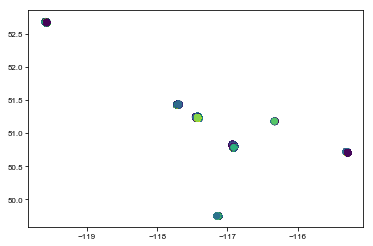

In [96]:
#plot these data
i=3
for i in range(7):
    geom = gdirs[i].read_shapefile('outlines')
#f, ax = plt.subplots()
    df=DF_Final[DF_Final.index==i]
    plt.scatter(x=df.long[i], y=df.lat[i], c=df.depth[i], cmap='viridis')#, s=10)#, ax=ax); #cmap='Blues',
#     geom.plot(ax=ax, facecolor='none', edgecolor='k');

In [97]:
import geopandas as gpd
shape=gpd.read_file("/home/pelto/GIS/outlines/ice_thick_glaciers.shp")
# shape

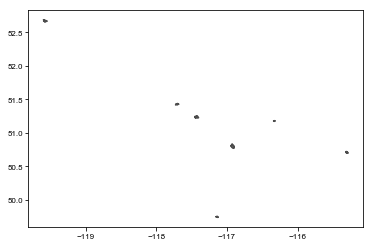

In [98]:
for i in np.arange(0,7,1):
    x,y=shape['geometry'][i].exterior.xy
    plt.plot(x,y,color='k',alpha=0.7)
plt.show()

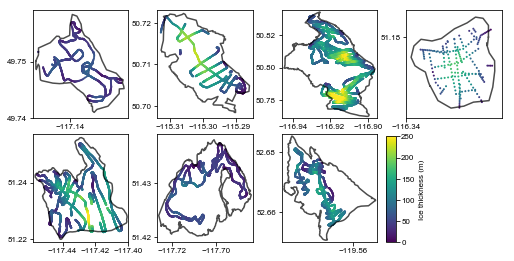

In [99]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='2'
pylab.rcParams['ytick.major.pad']='2'

fig, axarr = plt.subplots(2, 4, sharey=False, sharex=False, figsize=(7,3.5))#(12, 6))
j, k = 0, 0

shape.sort_values('CenLat', inplace=True, ascending=True) #sort the shapefile objects by latitude
GIDX= shape.index # save an index of the shapefiles
count=0

for i in range(7):
       
    df=DF_Final[DF_Final.index==i]
    im = axarr[j, k].scatter(df.long[i], df.lat[i], c=df.depth[i], cmap='viridis', vmax=250, vmin=0, s=1.)    
#     axarr[j, k].set_title(glacier[i])
       
    x,y=shape['geometry'][GIDX[count]].exterior.xy
    axarr[j, k].plot(x,y,color='k',alpha=0.7)
    
    ymin = np.round(min(y),3) -0.001
    ymax = np.round(max(y),3) + 0.001
    xmin = np.round(min(x),3) -0.001
    xmax = np.round(max(x),3) + 0.001

    axarr[j, k].set_xlim(xmin, xmax )
    axarr[j, k].set_ylim(ymin, ymax )
#     axarr[j, k].set_xticks(np.round(np.arange(xmin, xmax, 0.02),2))
#     axarr[j, k].ticklabel_format(useOffset=False)
    axarr[1, 3].axis('off')
#     axarr[j, k].set_yticks(np.round(np.arange(ymin, ymax, 0.02),2))
    if count == 2 or count == 4 or count == 6:
        axarr[j,k].yaxis.set_major_locator(ticker.MultipleLocator(0.02))
    else:
        axarr[j,k].yaxis.set_major_locator(ticker.MultipleLocator(0.01))
        
    if count == 1: #or count == 3:
        axarr[j,k].xaxis.set_major_locator(ticker.MultipleLocator(0.01))
    else:
        axarr[j,k].xaxis.set_major_locator(ticker.MultipleLocator(0.02))
    if count == 6:
        axarr[j,k].xaxis.set_major_locator(ticker.MultipleLocator(0.04))
    
    count+=1  # work through the index
    
    k += 1

    if i == 3: #changed to 2, 1 worked for 2x2 panel plot
        j += 1
        k = 0
fig.subplots_adjust(bottom=0.06, top=0.98, left=0.06, right=0.99, wspace=0.3, hspace=0.15) 

#Add an axes at position rect [left, bottom, width, height] where all quantities are in fractions of figure width and height
cb_ax = fig.add_axes([0.76, 0.06, 0.02, 0.42]) 
cbar = fig.colorbar(im, cax=cb_ax, label='Ice thickness (m)')
          
# plt.colorbar(im, pad=0.00, label='Ice thickness (m)')  
# plt.tight_layout(pad=0)
plt.savefig(products_dir + 'ice_thickness_all.pdf', dpi=300) 